In [629]:
# Import necesary modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 1. Mathematical Model

The idea of this notebook is to practice our understanding of quantum composite systems by analyzing the 1D chain of spins. We start by defining the Pauli matrices for a given one-spin system:

$$\sigma^x = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} $$

$$\sigma^y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix} $$

$$\sigma^z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} $$


Then we define the following operator of the composite system:

$$\sigma^{a}_j= I^{\otimes j-1}\otimes \sigma^{a} \otimes I^{\otimes N-j}$$

Where $I$ is the identity operator, $j\in\mathbb{Z} \wedge 1\geq j \leq N$ and $a\in\{x,y,z\}$. Now, given $J_x,J_y,J_z \in\mathbb{R}$, the Hamiltonian of the system is defined as:

$$H = -\frac{1}{2}\sum^{N}_{j=1} \left(J_x\sigma_{j}^x\sigma_{j+1}^x + J_y\sigma_{j}^y\sigma_{j+1}^y + J_z\sigma_{j}^z\sigma_{j+1}^z + h\sigma_{j}^z\right) \ ,$$
where $h$ is the intensity of an external magnetic field in the $z$-direction and periodic boundary conditions (PBC) are assumed.

The task is to numerically find the energy spectrum (finding the energy eigenvalues) and the eigenstates of the system known as *Heisenberg's Model*, where $J_x=J_y=J_z=J$, for different values of $J$ and $h$.

# 2. Proposing a solution for the problem

We are asked to find values of energy $\epsilon$ and states $|\epsilon\rangle$ that verify

$$H|\epsilon\rangle = \epsilon|\epsilon\rangle$$

By definition, the state $|\epsilon\rangle$ is defined by:

$$|\epsilon\rangle = \bigotimes_{j=1}^N |\epsilon_j\rangle \ ,$$

and
 
$$H = \sum_{\epsilon} \epsilon|\epsilon\rangle\langle\epsilon|$$

To solve the problem at hand, we're going to focus on getting $H$ to be represented by a 2-D matrix, so that we can apply useful eigenvalue solvers like `numpy.linalg.eig`. 

Let's begin by defining a basis of the composite Hilbert space of states $\mathbb{H}$ with dimension $\dim(H) = M^N$:

$$\{|\psi_1\rangle\otimes|\phi_1\rangle\otimes\cdots\otimes|\alpha_1\rangle, |\psi_1\rangle\otimes|\phi_1\rangle\otimes\cdots\otimes|\alpha_2\rangle,..., |\psi_M\rangle\otimes|\phi_M\rangle\otimes\cdots\otimes|\alpha_M\rangle\}$$

Any given state of $\mathbb{H}$ can be written as 

$$|\psi\rangle = c_{1,1,...,1}|\psi_1\phi_1\cdots\alpha_1\rangle + \cdots + c_{M,M,...,M}|\psi_M\phi_M\cdots\alpha_M\rangle\ ,$$

but this way of refering to the states generates the following way of refering to a given operator $H$ of $\mathbb{H}$:

$$ H = \sum_{i,j,\cdots,k \\ i',j',\cdots,k'} |\psi_i\phi_j\cdots\alpha_k\rangle H_{i,j,\cdots,k}^{i',j',\cdots,k'}\langle\psi_{i'}\phi_{j'}\cdots\alpha_{k'}| \ \ ; H_{i,j,\cdots,k}^{i',j',\cdots,k'}\equiv \langle\psi_i\phi_j\cdots\alpha_k|H|\psi_{i'}\phi_{j'}\cdots\alpha_{k'}\rangle $$

Notice this get's really hard to follow when several subsystems are involved.

On the other hand, we can represent $|\psi\rangle$ as

$$|\psi\rangle \doteq \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \\ c_{M^N - 1} \end{bmatrix} \ ,$$

where each coefficient $c_i$ is associated with a given base state $|c_i\rangle$, for example $|c_2\rangle = |\psi_1\phi_1\cdots\alpha_2\rangle$. This mapping is particularly easy to perform when every subsystem has the same dimensionality $M$, which is the case for this problem.

For the Heisenberg model, we know that every subsystem consisting of a single spin has a dimension $M=2$. We can create a mapping for any given index $n$ to the indexes $\psi_n, \phi_n, \cdots, \alpha_n$:

$$\alpha_n = n_0\ //\  M^{N - 1}$$
$$\vdots$$
$$\phi_n = n_{N-2}\ //\ M^{1}$$
$$\psi_n = n_{N-1}\ //\ M^{0}$$

where the variable $n_i$ is recursively defined as $n_{i+1} = n_{i} - (n_{i}\ //\ M^{N-i-1})\cdot M^{N-i-1}$, and the operator $//$ represents integer division, defined as 

$$\forall a,b \in \mathbb{Z}, a\ //\ b : a = (a\ //\ b)\cdot b + a\mod b$$

Having defined the mapping, it is easy to now define and calculate the representation of $H$ as:

$$H = \sum_{i,j} |c_i\rangle H_{i,j} \langle c_j| \ \ ; H_{i,j} \equiv \langle c_i|H|c\rangle$$

And calculating the eigenenergies and eigenstates is straightforward from there.

# 3. Building the code for the simulations

In [764]:
# 1 - DEFINE PAULI MATRICES
sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])


# 2 - DEFINE 1-SPIN SYSTEM OBJECTS
# Function that initializes a state
def init_state(base,weights):
    '''
    Params:
        base : pandas Series
            Series of N numpy arrays of shape (M,1) that are 
            used as the base to build the state representation.
        weights : pandas Series
            Series of N complex weights representing the state 
            in the given base.
    Output:
        Returns the state's representation in the given
        base as a numpy array of shape (M,1).
    '''
    return weights.to_numpy().reshape(base[0].shape)

# Inner product function
def inner_prod(bra_state,ket_state):
    '''
    Params:
        bra_state : numpy array of shape (N,1)
            State that is going to be used as a bra, but in 
            ket representation.
        ket_state : numpy array of shape (N,1)
            State that is going to be the ket of the operation,
            also in ket representation.
    Output:
        Returns the inner product, as defined for Hilbert 
        spaces: < bra_state | ket_state >
    '''
    bra = np.conjugate(np.transpose(bra_state))
    
    return (bra @ ket_state)[0][0]

def base_change_matrix(old_base,new_base):
    '''
    Params:
        old_base : pandas Series
            Series of N numpy arrays of shape (M,1) that
            represent the old base.
        new_base : pandas Series
            Series of N numpy arrays of shape (M,1) that
            represent the new orthonormal base.
        
    Output:
        Returns a complex numpy array of shape (M,M) that 
        can be used to change the representation of a state 
        |a> or an operator H from the old base to the new 
        base.
    '''
    size = old_base.shape[0]
    matrix = np.zeros(shape=(size,size),dtype='complex')
    for i in range(size):
        for j in range(size):
            matrix[i,j] += inner_prod(old_base[i],new_base[j])    
    det = np.linalg.det(matrix)     
    if not np.isclose(det**2,1):
        print('Transformation matrix determinant is '+str(det))
        print('Warning: transformation is not unitary.')
    
    return matrix

# State of a single spin
class SpinState():
    def __init__(self,base,weights):
        '''
        Params:
            base : pandas Series
                Series of N numpy arrays of shape (M,1) that
                represent the base used to build the state.
            weights : pandas Series
                Series of N complex weights representing the state 
                in the given base.
        Output:
            Initializes the SpinState object.
        '''
        self.base = base
        self.state = init_state(base, weights)
        
    def print_info(self):
        '''
        Output:
            Prints the attributes of the object.
        '''
        print('Base:')
        print(self.base)
        print('State:')
        print(self.state)
        
    def change_base(self,new_base,verbose=0):
        '''
        Params:
            new_base : pandas Series
                Series of N numpy arrays of shape (M,1) that
                represent the new base.
            verbose : int
                Default is 0 and doesn't print a message. If 1
                then prints a message to let the user know a 
                transformation of base is being performed.
        Output:
            Changes the object's state, base and weight attributes 
            using the given new orthonormal base.
        '''
        # Check verbose
        if verbose != 0 and verbose != 1:
            print('SpinState.change_base method error: '+
                 'verbose must be either 0 or 1.')
            return
        if verbose == 1:
            print('Performing change of base.\n')
        # Perform change of base
        old_base = self.base
        old_state = self.state
        O = base_change_matrix(old_base,new_base)
        O_dagger = np.conjugate(np.transpose(O))
        self.state = O_dagger@old_state
        self.base = new_base
        
        
    def get_state(self,verbose=0):
        '''
        Params:
            verbose : int
                Wether to print the output, 1, or not, 0 (default).
        Output:
            Returns a 3 string representation of the spin state.
            Can only be used for 2-state basis.
        '''
        # Check for two-state base
        if self.base.shape[0] != 2:
            print('SpinState.get_state method error: basis size must be 2')
            return
        # Check verbose
        if verbose != 0 and verbose != 1:
            print('SpinState.get_state method error:'+\
                  ' verbose must be either 0 or 1')
        # Build strings
        string1,string2,string3 = str(np.round(self.state[0][0],2)).ljust(13),\
                                    'O------------',\
                                  str(np.round(self.state[1][0],2)).ljust(13)
        if verbose == 1:
            print(string1+'\n'+string2+\
                 '\n'+string3)
        return [string1,string2,string3]
    
    
    def normalize_state(self):
        '''
        Output:
            Normalizes the state of the spin using
            the Hilbert space definition of inner 
            product.
        '''
        scale = np.sqrt(inner_prod(self.state,self.state))
        new_state = self.state / scale
        self.state = new_state
    
    
    def apply_operator(self,H):
        '''
        Params:
            H : numpy array
                Operator that is going to be applied. If state
                is of shape (M,1), then the operator must be
                of shape (M,M).
        Output:
            Returns the result of applying the operator 
            to the state.
        '''
        return H@self.state
    
    
    def update_state(self,U,force_unitary=False):
        '''
        Params:
            U : numpy array
                Evolution operator. If state is of shape (M,1), 
                then the operator must be of shape (M,M).
            force_unitary : bool
                Whether to force the evolution to be unitary, True,
                or not, False (default).
        Output:
            Updates the state of the spin using the evolution
            operator.
        '''
        new_state = U@self.state
        self.state = new_state
        if force_unitary:
            self.normalize_state()
            
            

# 3 - DEFINE COMPOSITE SYSTEM OBJECTS
def index_to_location(shape, index):
    '''
    Params:
        shape : tuple or list
            Shape of the composite system base, (N,M,M,1),
            where N is the number of subsystems and M the 
            dimension of each subsystem.
        index : int
            1-D index to be mapped.
    Output:
        Returns a list with the location associated with 
        the given index, for the given shape.
    '''
    N, M = shape[0], shape[1]
    remaining = index
    location = []
    for i in range(N):
        # Use modulus operation
        level = int(M**(N-i-1))
        level_val = remaining // level
        location.append(level_val)
        # Update remaining
        remaining -= level_val*level
        
    return location

    
def get_base_state(base_list, index):
    '''
    Params:
        base_list : numpy array
            Shape must be (N,M,M,1), where N is the number of
            subsystems and M the dimension of each subsystem.
        index : int
            1-D index for the base state.
            
    Output:
        Returns the composite base state associated to the 
        given index.
    '''
    # Get location for the given index
    location = index_to_location(base_list.shape, index)
    
    # Fetch base states for each level
    base_states = []
    for i in range(base_list.shape[0]):
        level_idx = location[i]
        base_states.append(base_list[i][level_idx])
    base_states = np.array(base_states, dtype='complex')
    return base_states
    
    
def generate_composite_state(weights):
    '''
    Params:
        weights : pandas Series
            Weights of each vector in the composite base.
            Must be of shape (N**M,1).
    Output:
        Returns the representation of the composite state
        in a given base as a numpy array of shape (N**M,1).
    '''
    shape = (weights.shape[0],1)
    return weights.to_numpy().reshape(shape)


def composite_inner_prod(bra_state, ket_state):
    '''
    Params:
        bra_state : numpy array of shape (N,M,1)
            Composite state that is going to be used as a bra, 
            but in ket representation.
        ket_state : numpy array of shape (N,M,1)
            Composite state that is going to be the ket of the 
            operation, also in ket representation in the same
            base as bra_state.
    Output:
        Returns the inner product, as defined for Hilbert 
        spaces: < bra_state | ket_state >
    '''
    # Notice we can take advantage of the previously defined
    # inner_prod() function
    # Calculate sub-products
    total = 1
    for n in range(bra_state.shape[0]):
        bra, ket = bra_state[n], ket_state[n]
        total *= inner_prod(bra,ket)
    
    return total
    
    
class CompositeState():
    def __init__(self, base_list, weights):
        '''
        Params:
            base_list : numpy array
                Shape must be (N,M,M,1), where N is the number of
                subsystems and M the dimension of each subsystem.
            weights : pandas Series.
                Weights of each state in the composite base.
                Must be of shape (N**M,1).
        Output:
            Initializes the CompositeState object.
        '''
        self.base_list = base_list
        self.state = generate_composite_state(weights)
        self.spin_states = None
        
        
    def print_info(self):
        '''
        Output:
            Prints the attributes of the object.
        '''
        print('Subsystems bases:')
        print(self.base_list)
        print('State:')
        print(self.state)
        
        
    def normalize_state(self):
        '''
        Output:
            Normalizes the CompositeState.state vector using
            the Hilbert space inner product definition.
        '''
        scale = np.sqrt(composite_inner_prod(self.state, self.state))
        new_state = self.state / scale
        self.state = new_state
        
    def apply_operator(self,H):
        '''
        Params:
            H : numpy array
                Operator that is going to be applied. If state
                is of shape (M**N,1), then the operator must be
                of shape (M**N,M**N).
        Output:
            Returns the result of applying the operator 
            to the state.
        '''
        return H@self.state
    
    
    def update_state(self,U,force_unitary=False):
        '''
        Params:
            U : numpy array
                Evolution operator. If state is of shape (M**N,1), 
                then the operator must be of shape (M**N,M**N).
            force_unitary : bool
                Whether to force the evolution to be unitary, True,
                or not, False (default).
        Output:
            Updates the state of the spin using the evolution
            operator.
        '''
        new_state = U@self.state
        self.state = new_state
        if force_unitary:
            self.normalize_state()
            
        
    def get_base_state(self, index):
        '''
        Params:
            index : int
                Index associated with a state of the system
                base.
        Output:
            Returns the base state specified by index.
        '''
        return get_base_state(self.base_list, index)
    
    
    def build_chain(self):
        '''
        Output: 
            Generates a list of SpinState objects, each of them
            associated with a subsystem of the CompositeState
            object. This can only be done when CompositeState.state
            is a product state.
        '''
        # Check if self.state is a product state
        if np.isclose(self.state,0).sum() == self.state.shape[0]-1:
            # Get product state
            prod_state = self.get_base_state(np.argmax(np.abs(self.state)))
            # Build list of SpinState objects
            list_spin_states = []
            size = self.base_list.shape[0]
            for i in range(size):
                # Get weights
                spin_state = SpinState(base=self.base_list[i],
                                weights=pd.Series(prod_state[i].flatten()))
                list_spin_states.append(spin_state)

            self.spin_states = list_spin_states
        else:
            print('CompositeState.build_chain method error: cannot perform operation because'+\
                 ' CompositeState.state is not a product state.')
            
        
    def show_chain(self):
        '''
        Output:
            Prints the chain from CompositeState.spin_states when
            the system is in a product state.
        '''
        if self.spin_states == None:
            self.build_chain()
        messages = ['','','']
        for i in range(len(self.spin_states)):
            spin = self.spin_states[i]
            m = spin.get_state()
            for j in range(3):
                messages[j] += m[j]
        for j in range(3):
            print(messages[j])
            
            
    def show_all_chains(self):
        '''
        Output:
            Sequentially prints all the product states
            that compose the CompositeState.state vector
        '''
        # Save initial information
        old_spin_states = self.spin_states
        # Print each chain with its weight
        for i in range(self.state.shape[0]):
            if not np.isclose(self.state[i][0],0):
                print('Weight: '+str(np.round(self.state[i][0],3)))
                # Get product state
                prod_state = self.get_base_state(i)
                # Build list of SpinState objects
                list_spin_states = []
                size = self.base_list.shape[0]
                for j in range(size):
                    # Get weights
                    spin_state = SpinState(base=self.base_list[j],
                                    weights=pd.Series(prod_state[j].flatten()))
                    list_spin_states.append(spin_state)

                self.spin_states = list_spin_states
                self.show_chain()
                print()
        # Retrieve initial information   
        self.spin_states = old_spin_states
            
    
    
class CompositeOperator():
    def __init__(self, base_list, operator_list):
        '''
        Params:
            base_list : numpy array
                Shape must be (N,M,M,1), where N is the number of
                subsystems and M the dimension of each subsystem.
            operator_list : numpy array
                Shape must be (N,M,M). Operators associated with
                each subsytem, that comprise the composite operator.
                The operators must be in the same representation as
                the states in base_list for each subsystem.
        Output:
            Initializes the CompositeOperator object.
        '''
        self.base_list = base_list
        self.operator_list = operator_list
        self.tensor = None
        self.CompositeState = None
        
    def apply_operator(self,base_state):
        '''
        Params:
            base_state : numpy array
                Base state of the composite system associated to
                the operator.
        Output:
            Returns the result of directly applying the base_list
            array to the base_state array. This result has the same
            shape as base_state.
        '''
        return self.operator_list@base_state
        
    def generate_tensor(self):
        '''
        Output:
            Initializes a numpy array atribute that can be used to 
            operate on CompositeState.state arrays. 
        '''
        # Let's get the coeficient for every base state
        # combination.
        K = int(self.base_list.shape[1]**self.base_list.shape[0])
        tensor = np.zeros(shape=(K,K), dtype='complex')
        for i in range(K):
            for j in range(K):
                bra = get_base_state(self.base_list,i)
                ket = get_base_state(self.base_list,j)
                tensor[i,j] += composite_inner_prod(bra,
                                        self.apply_operator(ket))
        
        self.tensor = tensor
        
    def get_eigen(self):
        '''
        Output: 
            Saves a dictionary with the eigen values, key 
            'eigenvalues', and the eigenstates, 'eigenstates'
            of the composite operator.
        '''
        values, states = np.linalg.eig(self.tensor)
        eigen_dict = {'eigenvalues':values, 
                      'eigenstates':states}
        
        self.eigen_dict = eigen_dict
    
    
    def plot_eigen(self, energies=True,states=True, 
                   filepath=None):
        '''
        Params:
            energies : bool
                Whether or not to plot the eigenenergies.
            states : bool
                Whether or not to draw the eigenstates
            filepath : str or None
                Path to save the plotted image. If None
                the plot doesn't get saved (default).
        Output:
            Plots the eigenenergies and eigenstates of the 
            operator.
        '''
        # Get eigen values
        eigen = self.eigen_dict
        if energies:
            fig = plt.Figure(figsize=(25,25))
            plt.hist(np.abs(eigen['eigenvalues']))
            plt.xticks(fontsize=15,rotation=20)
            plt.yticks(fontsize=15)
            plt.xlabel('Energy',fontsize=16)
            plt.ylabel('Count',fontsize=16)
            plt.tight_layout()
            if filepath != None:
                plt.savefig(filepath)
            plt.show();
            
        if states:
            # Let's graph all the chains of every 
            # eigenstate
            for i in range(len(eigen['eigenstates'])):
                print('Eigenstate %d of %d, energy = %.3f' % (i+1, 
                                        len(eigen['eigenstates']),
                                        np.abs(eigen['eigenvalues'][i])))
                weights = eigen['eigenstates'][i]
                self.CompositeState = CompositeState(self.base_list,
                    pd.Series(weights.flatten()))
                
                self.CompositeState.show_all_chains()
                print()
                
        
    def show_eigenstate(self,index):
        '''
        Params:
            index : int
                Index of the specified eigenstate in 
                CompositeState.eigen_dict['eigenstate']
        Output:
            Graphs the specified eigenstate of the operator.
        '''
        weights = self.eigen_dict['eigenstates'][index]
        self.CompositeState = CompositeState(self.base_list,
            pd.Series(weights.flatten()))

        self.CompositeState.show_all_chains()
        print()

## 3.1 Small example of how to use the code

In [664]:
base = pd.Series([np.array([[1],[0]]),np.array([[0],[1]])])
weights = pd.Series([1,0.5])
S = SpinState(base,weights)
S.normalize_state()
S.print_info()

H = np.array([[0,1],[1,0]])
S.update_state(H)

Base:
0    [[1], [0]]
1    [[0], [1]]
dtype: object
State:
[[0.89442719]
 [0.4472136 ]]


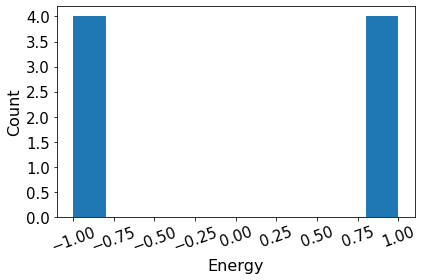

Eigenstate 1 of 8, energy = 1.000
Weight: (-0-0.707j)
(1+0j)       (1+0j)       (1+0j)       
O------------O------------O------------
0j           0j           0j           

Weight: (0.707+0j)
(1+0j)       (1+0j)       0j           
O------------O------------O------------
0j           0j           (1+0j)       


Eigenstate 2 of 8, energy = 1.000
Weight: 0.707j
0j           0j           (1+0j)       
O------------O------------O------------
(1+0j)       (1+0j)       0j           

Weight: (0.707+0j)
0j           0j           0j           
O------------O------------O------------
(1+0j)       (1+0j)       (1+0j)       


Eigenstate 3 of 8, energy = 1.000
Weight: 0.707j
(1+0j)       0j           (1+0j)       
O------------O------------O------------
0j           (1+0j)       0j           

Weight: (0.707+0j)
(1+0j)       0j           0j           
O------------O------------O------------
0j           (1+0j)       (1+0j)       


Eigenstate 4 of 8, energy = 1.000
Weight: (-0-0.707j)
0j      

In [665]:
base_list = np.array([
    [[[1],[0]],[[0],[1]]],
    [[[1],[0]],[[0],[1]]],
    [[[1],[0]],[[0],[1]]]
])
weights = pd.Series([0,0,0.7,0,0,0,0,0.7])
C = CompositeState(base_list, weights)

Op = np.array([
    sigma_x,
    sigma_y,
    sigma_z,
])
H = CompositeOperator(base_list,Op)
H.generate_tensor()
H.get_eigen()
H.plot_eigen()

# 4. Designing a specific pipeline for the Heisenberg system

In [718]:
# 1 - SOME AUXILIARY FUNCTIONS
def sigma_j_a(N,j,a):
    '''
    Params:
        N : int
            Number of spins in the system.
        j : int
            Spin index to place sigma_a, must be
            between 1 and N.
        a : str or int
            Wheter to use sigma_x, 'x' or 1, sigma_y,
            'y' or 2, or sigma_z, 'z' or 3.
    Output:
        Returns a numpy array containing the representation
        of the sigma_j_a operator in the base used for 
        defining the Pauli matrices. The definition of
        sigma_j_a is:
        
        sigma_j_a = I^(@j-1) @ sigma_a @ I^(@N-j)
    '''
    # Define I
    I = sigma_0
    # Select sigma_a
    if a == 'x' or a == 1:
        sigma_a = sigma_x
    elif a == 'y' or a == 2:
        sigma_a = sigma_y
    elif a == 'z' or a == 3:
        sigma_a = sigma_z
    
    # Build array
    operator = []
    for i in range(N):
        k = i+1
        if k <= j-1:
            operator.append(I)
        elif k == j:
            operator.append(sigma_a)
        else:
            operator.append(I)
            
    return np.array(operator,dtype='complex')


def operator_list_mult(A,B):
    '''
    Params:
        A : numpy array
            Left-side operator.
        B : numpy array
            Right-side operator.
    Output:
        Returns the result of the operation A@B,
        performed for operators A and B in list 
        representation.
    '''
    total = []
    for i in range(A.shape[0]):
        total.append(A[i]@B[i])
    return np.array(total,dtype='complex')

def build_Heisenberg_H(N,J,h):
    '''
    Params:
        N : int
            Number of spins to include in the system.
        J : float
            Heisenberg model coupling constant between adyacent
            spins.
        h : float
            Heisenberg model external field coupling constant.
    Output:
        Returns the Hamiltonian representation associated with the 
        system, as a numpy array of shape (N,2,2).
    '''
    # Define scale factor
    scale = -1/2
    # Initialize H
    H = np.zeros(shape=(N,2,2),dtype='complex')
    
    # lambda expresion to make sintax easier to read
    mult = lambda x,y: operator_list_mult(x,y)
    # Perform sumation
    for i in range(N):
        j = i+1
        row = np.zeros(shape=(N,2,2),dtype='complex')
        
        # Add spin couplings with PBC
        for u in ['x','y','z']:
            if j == N:
                row += J*mult(sigma_j_a(N,j,u),sigma_j_a(N,1,u))
            else:
                row += J*mult(sigma_j_a(N,j,u),sigma_j_a(N,j+1,u))
                
        # Add external field coupling
        row += h*sigma_j_a(N,j,a='z')
        
        # Add to H
        H += row
        
    # Scale H and return
    return scale*H


def build_Heisenberg_base(N):
    '''
    Params:
        N : int
            Number of spins to include in the system.
    Output:
        Returns a base_list with the specified amount of spins.
    '''
    total = []
    for i in range(N):
        total.append(np.array([[[1],[0]],[[0],[1]]]))
        
    return np.array(total, dtype='complex')


# 2 - CALCULATIONS PIPELINE 
def run_Heisenberg(N,J,h,verbose=0):
    '''
    Params:
        N : int
            Number of spins to include in the system.
        J : float
            Heisenberg model coupling constant between adyacent
            spins.
        h : float
            Heisenberg model external field coupling constant.
        verbose : int 0, 1 or 2
            Wheter to show current run status, 1, final run status, 2, 
            or no status, 0 (default).
    Output:
        Returns the CompositeOperator object associated with the 
        system, with found eigenvalues and eigenstates. Also returns
        a time_log with the performance of the run.
    '''
    # Let's time every step and the overall performance
    t0 = time.time()
    # Build Hamiltonian as a CompositeOperator
    if verbose == 1:
        print('Building system...')
    H = CompositeOperator(base_list=build_Heisenberg_base(N),
                        operator_list=build_Heisenberg_H(N,J,h))
    t1 = time.time()
    if verbose == 1:
        print('Elapsed time: %.3f seconds' % (t1-t0))
        print('\nGenerating 2-D tensor...')
    # Generate tensor for H
    H.generate_tensor()
    t2 = time.time()
    if verbose == 1:
        print('Elapsed time: %.3f seconds' % (t2-t1))
        print('\nCalculating eigenvalues and eigenstates...')
    # Get eigenvalues and eigenstates
    H.get_eigen()
    t3 = time.time()
    if verbose == 1:
        print('Elapsed time: %.3f seconds' % (t3-t2))
    if verbose == 1 or verbose == 2:
        print('\nProcess completed. Total wall time: %.3f seconds' % (t3-t0))
    
    # Build log to compare peformances
    time_log = {'Build':(t1-t0), 'Tensor':(t2-t1), 'Eigen':(t3-t2), 
               'Total':(t3-t0)}
    
    return H, time_log


def compare_performance(logs_list, labels=None,
                        yscale='linear',xlabel=None, 
                        filepath=None):
    '''
    Params:
        logs_list : list
            List of run_Heisenberg()[1] results.
        labels : list (optional)
            List of experiment labels.
        yscale : str (optional)
            Tipe of y-scale: 'linear', 'log', ...
        xlabel : str or None (optional)
            Label for x-axis, None by default.
        filepath : str or None (optional)
            Path to which save the plot, None by default.
    Output:
        Compares different the performance of different
        experiments.
    '''
    fig = plt.Figure(figsize=(20,15))
    # Plot all the data
    keys = ['Build','Tensor','Eigen','Total']
    for i in range(4):
        data = []
        for log in logs_list:
            data.append(log[keys[i]])
        plt.plot(np.linspace(start=1,
                             stop=len(logs_list),
                             num=len(logs_list)),
                 data,'o--',label=keys[i])
    if labels != None:
        plt.xticks(np.linspace(start=1,
                             stop=len(logs_list),
                             num=len(logs_list)),
            labels=labels,fontsize=18)
    else:
        plt.xticks(np.linspace(start=1,
                             stop=len(logs_list),
                             num=len(logs_list)),
                   fontsize=18)
    plt.yscale(yscale)
    plt.yticks(fontsize=18)
    if xlabel != None:
        plt.xlabel(xlabel,fontsize=18)
    else:
        plt.xlabel('Experiment',fontsize=18)
    plt.ylabel(r'Time $[s]$',fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    if filepath != None:
        plt.savefig(filepath)
    plt.show();

# 5. Running some experiments
## 5.1 Testing performance for different values of $N$

Let's fix the values $J=1$ and $h=1$ and see what happens for different values of $N$. 

In [707]:
H_N, logs_N = [], []
N_values = [2,4,6,8,10,12]
for i in range(len(N_values)):
    N = N_values[i]
    print('\nRun %d of %d, N = %d' % (i+1,len(N_values),N))
    H_i, log_i = run_Heisenberg(N=N,J=1,h=1,verbose=2)
    H_N.append(H_i)
    logs_N.append(log_i)


Run 0 of 6, N = 2

Process completed. Total wall time: 0.002 seconds

Run 1 of 6, N = 4

Process completed. Total wall time: 0.026 seconds

Run 2 of 6, N = 6

Process completed. Total wall time: 0.178 seconds

Run 3 of 6, N = 8

Process completed. Total wall time: 3.007 seconds

Run 4 of 6, N = 10

Process completed. Total wall time: 58.771 seconds

Run 5 of 6, N = 12

Process completed. Total wall time: 1139.986 seconds


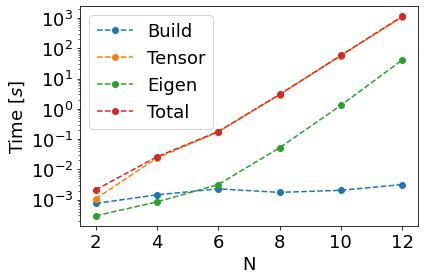

In [719]:
compare_performance(logs_N, labels=[str(N) for N in N_values],
                    xlabel='N', yscale='log',filepath='N_experiments.png')

## 5.2 Experimenting with different values of $J$

We'll fix $N=8$ and $h=1$, and see how the system reacts to different values of $J$, both positive and negative.

In [755]:
H_J, logs_J = [], []
J_values = [-4,-2,0,2,4,8]
for i in range(len(J_values)):
    J = J_values[i]
    print('\nRun %d of %d, J = %d' % (i+1,len(J_values),J))
    H_i, log_i = run_Heisenberg(N=8,J=J,h=1,verbose=2)
    H_J.append(H_i)
    logs_J.append(log_i)


Run 1 of 6, J = -4

Process completed. Total wall time: 3.042 seconds

Run 2 of 6, J = -2

Process completed. Total wall time: 3.046 seconds

Run 3 of 6, J = 0

Process completed. Total wall time: 2.975 seconds

Run 4 of 6, J = 2

Process completed. Total wall time: 3.062 seconds

Run 5 of 6, J = 4

Process completed. Total wall time: 3.019 seconds

Run 6 of 6, J = 8

Process completed. Total wall time: 3.043 seconds


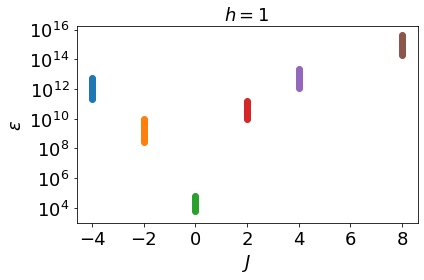

In [756]:
fig = plt.Figure(figsize=(20,15))
for i in range(len(H_J)):
    H_j = H_J[i]
    data = np.abs(H_j.eigen_dict['eigenvalues'])
    x = np.ones((len(data),1))*J_values[i]
    plt.scatter(x,data)
plt.yscale('log')
plt.title(r'$h=1$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$J$',fontsize=18)
plt.ylabel(r'$\epsilon$',fontsize=18)
plt.ylim(bottom=1e3)
plt.tight_layout()
plt.savefig('J_experiments_1.png')
    
plt.show();

Now let's see what happens when $h=0$...

In [757]:
H_J, logs_J = [], []
J_values = [-4,-2,0,2,4,8]
for i in range(len(J_values)):
    J = J_values[i]
    print('\nRun %d of %d, J = %d' % (i+1,len(J_values),J))
    H_i, log_i = run_Heisenberg(N=8,J=J,h=0,verbose=2)
    H_J.append(H_i)
    logs_J.append(log_i)


Run 1 of 6, J = -4

Process completed. Total wall time: 3.045 seconds

Run 2 of 6, J = -2

Process completed. Total wall time: 3.018 seconds

Run 3 of 6, J = 0

Process completed. Total wall time: 2.979 seconds

Run 4 of 6, J = 2

Process completed. Total wall time: 2.993 seconds

Run 5 of 6, J = 4

Process completed. Total wall time: 3.011 seconds

Run 6 of 6, J = 8

Process completed. Total wall time: 3.015 seconds


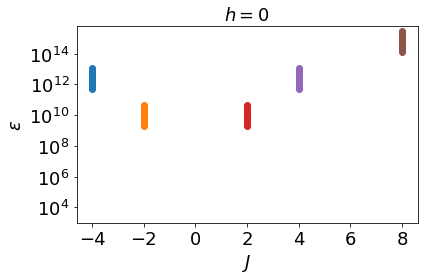

In [758]:
fig = plt.Figure(figsize=(20,15))
for i in range(len(H_J)):
    H_j = H_J[i]
    data = np.abs(H_j.eigen_dict['eigenvalues'])
    x = np.ones((len(data),1))*J_values[i]
    plt.scatter(x,data)
plt.yscale('log')
plt.title(r'$h=0$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$J$',fontsize=18)
plt.ylabel(r'$\epsilon$',fontsize=18)
plt.ylim(bottom=1e3)
plt.tight_layout()
plt.savefig('J_experiments_2.png')
    
plt.show();

It can be observed that the energy spectrum is perfectly symmetric when $h=0$, and the case $J=0$ has a completely degenerate single eigenvalue $\epsilon = 0$.

## 5.3 Experimenting with different values of $h$

We'll fix $N=8$ and $J=4$, and see how the system reacts to different values of $h$, both positive and negative.

In [759]:
H_h, logs_h = [], []
h_values = [-4,-2,-1,-0.5,0,0.5,1,2,4,8]
for i in range(len(h_values)):
    h = h_values[i]
    print('\nRun %d of %d, h = %d' % (i+1,len(h_values),h))
    H_i, log_i = run_Heisenberg(N=8,J=4,h=h,verbose=2)
    H_h.append(H_i)
    logs_h.append(log_i)


Run 1 of 10, h = -4

Process completed. Total wall time: 3.042 seconds

Run 2 of 10, h = -2

Process completed. Total wall time: 2.990 seconds

Run 3 of 10, h = -1

Process completed. Total wall time: 3.006 seconds

Run 4 of 10, h = 0

Process completed. Total wall time: 2.971 seconds

Run 5 of 10, h = 0

Process completed. Total wall time: 2.989 seconds

Run 6 of 10, h = 0

Process completed. Total wall time: 3.017 seconds

Run 7 of 10, h = 1

Process completed. Total wall time: 3.014 seconds

Run 8 of 10, h = 2

Process completed. Total wall time: 3.028 seconds

Run 9 of 10, h = 4

Process completed. Total wall time: 3.008 seconds

Run 10 of 10, h = 8

Process completed. Total wall time: 3.029 seconds


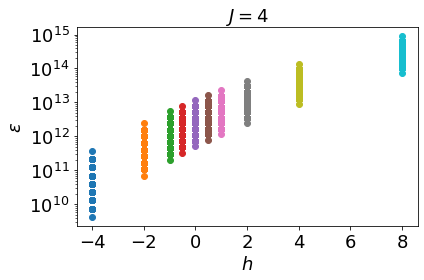

In [760]:
fig = plt.Figure(figsize=(20,15))
for i in range(len(H_h)):
    H_h_j = H_h[i]
    data = np.abs(H_h_j.eigen_dict['eigenvalues'])
    x = np.ones((len(data),1))*h_values[i]
    plt.scatter(x,data)
plt.yscale('log')
plt.title(r'$J=4$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$h$',fontsize=18)
plt.ylabel(r'$\epsilon$',fontsize=18)
plt.tight_layout()
plt.savefig('h_experiments_1.png')
    
plt.show();

# 6. Analizing the eigenstates of a system with $N=4$

Let's simulate the system characterised by $N=4$, $J=2$ and $h=1$.

In [771]:
H_sim, log_sim = run_Heisenberg(N=4,J=2,h=1,verbose=2)


Process completed. Total wall time: 0.025 seconds


Now let's see what do the eigenenergies and eigenstates look like...

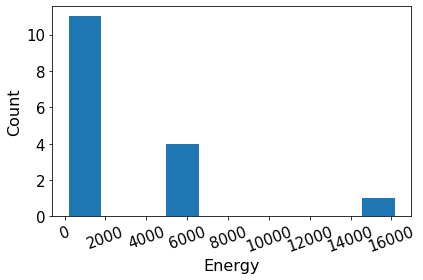

In [772]:
H_sim.plot_eigen(states=False)

In [773]:
# Let's see what the first eigenstate looks like
H_sim.show_eigenstate(0)

Weight: (0.691+0j)
(1+0j)       (1+0j)       (1+0j)       (1+0j)       
O------------O------------O------------O------------
0j           0j           0j           0j           

Weight: (0.127-0j)
(1+0j)       (1+0j)       (1+0j)       0j           
O------------O------------O------------O------------
0j           0j           0j           (1+0j)       

Weight: (-0.029-0j)
(1+0j)       (1+0j)       0j           (1+0j)       
O------------O------------O------------O------------
0j           0j           (1+0j)       0j           

Weight: (0.59+0j)
(1+0j)       (1+0j)       0j           0j           
O------------O------------O------------O------------
0j           0j           (1+0j)       (1+0j)       

Weight: (-0.016-0.003j)
(1+0j)       0j           (1+0j)       (1+0j)       
O------------O------------O------------O------------
0j           (1+0j)       0j           0j           

Weight: (-0.006-0.01j)
(1+0j)       0j           (1+0j)       0j           
O------------O----------